# Aflatoxin Risk Classification in Maize Grains (Rwanda)

This notebook explores and analyzes a dataset provided by Aflakiosk Ltd. It contains grain quality parameters used to classify maize into four consumption categories based on aflatoxin risk thresholds.

The ultimate goal is to train a machine learning model that can predict whether a maize grain sample is:
- **Safe for Children (≤5 μg/kg)**
- **Safe for Adults (5-20 μg/kg)**
- **Animal Feeding Only (20-300 μg/kg)**
- **Unsafe for Any Use (>300 μg/kg)**

This EDA phase performs an in-depth analysis to:
- Understand the data
- Detect data quality issues
- Reveal feature-target relationships
- Prepare for model training


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from scipy.stats import zscore

In [2]:
df = pd.read_csv('data.csv')
df.head()


,id,batch_label,batch_quantity_mts,batch_crop,batch_product,product_origin,year,test_type,storage_type,moisture_maize_grain,...,url,theurl,expiration,production,batchnumber,batchnumberflour,linkedclient,linkedtones,labtested,sampleowne
0,1,Outside- tarpaulin,NaN,Maize,Grain,Uganda,2022.0,First,Store,14.2,...,1.0,www.aflakiosk.com,NaN,NaN,NaN,NaN,NaN,NaN,Mubende Laboratory,NaN
1,2,Inside the Atore (lotA) Left,NaN,Maize,Grain,Uganda,2022.0,First,Store,14.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mubende Laboratory,NaN
2,3,In the middle (inside the store),NaN,Maize,Grain,Uganda,2022.0,First,warehouse,13.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mubende Laboratory,NaN
3,4,Trucks,NaN,Maize,Grain,Uganda,2022.0,First,Store,14.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mubende Laboratory,NaN
4,14,Visionary- sample 1,32.0,Maize,Grain,Tanzania,2022.0,First,WareHouse,12.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Mubende Laboratory,NaN


In [3]:
df.columns

Index(['id', 'batch_label', 'batch_quantity_mts', 'batch_crop',
       'batch_product', 'product_origin', 'year', 'test_type', 'storage_type',
       'moisture_maize_grain', 'Immaturegrains', 'Discolored_grains',
       'Liveinfestation', 'total_aflatoxins_ug_kg_maize_grain',
       'abnormal_odours_maize_grain', 'final_grade', 'test_date',
       'organisation_id', 'nvcondition', 'season', 'tester', 'description',
       'Other_colors', 'broken_kernels_percent_maize_grain',
       'foreign_matter_percent_maize_grain', 'pest_damaged', 'rotten',
       'condsample', 'sampledby', 'bags_sampled', 'districts', 'price',
       'moisturechanges', 'romerid', 'totaldefective', 'url', 'theurl',
       'expiration', 'production', 'batchnumber', 'batchnumberflour',
       'linkedclient', 'linkedtones', 'labtested', 'sampleowne'],
      dtype='object')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 45 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   id                                  1799 non-null   int64  
 1   batch_label                         1799 non-null   object 
 2   batch_quantity_mts                  1705 non-null   float64
 3   batch_crop                          1799 non-null   object 
 4   batch_product                       1799 non-null   object 
 5   product_origin                      1728 non-null   object 
 6   year                                1727 non-null   float64
 7   test_type                           1440 non-null   object 
 8   storage_type                        251 non-null    object 
 9   moisture_maize_grain                1722 non-null   float64
 10  Immaturegrains                      1272 non-null   float64
 11  Discolored_grains                   1240 no

### Deleting sensitive dat like the names of the testers and samplers

In [10]:
df = df.drop(columns=["sampleowne", "tester", "sampledby"], errors='ignore')


In [11]:
df.isnull().sum()

id                                       0
batch_label                              0
batch_quantity_mts                      94
batch_crop                               0
batch_product                            0
product_origin                          71
year                                    72
test_type                              359
storage_type                          1548
moisture_maize_grain                    77
Immaturegrains                         527
Discolored_grains                      559
Liveinfestation                        531
total_aflatoxins_ug_kg_maize_grain      17
abnormal_odours_maize_grain            523
final_grade                             73
test_date                                0
organisation_id                          0
nvcondition                           1799
season                                 557
description                           1548
Other_colors                           691
broken_kernels_percent_maize_grain     545
foreign_mat

### Checking if there's a more than one crop

In [12]:
print(df["batch_crop"].unique())


['Maize']


### Cheching Unique Products in the dataset

In [14]:
print(df["batch_product"].value_counts())



batch_product
Grain    1316
Flour     382
Feed      101
Name: count, dtype: int64


We are going to train on 1316 datapoint to predict aflatoxin since we will be training on maize grain

In [15]:
grain_data = df[df["batch_product"] == "Grain"]


In [17]:
grain_data.columns

Index(['id', 'batch_label', 'batch_quantity_mts', 'batch_crop',
       'batch_product', 'product_origin', 'year', 'test_type', 'storage_type',
       'moisture_maize_grain', 'Immaturegrains', 'Discolored_grains',
       'Liveinfestation', 'total_aflatoxins_ug_kg_maize_grain',
       'abnormal_odours_maize_grain', 'final_grade', 'test_date',
       'organisation_id', 'nvcondition', 'season', 'description',
       'Other_colors', 'broken_kernels_percent_maize_grain',
       'foreign_matter_percent_maize_grain', 'pest_damaged', 'rotten',
       'condsample', 'bags_sampled', 'districts', 'price', 'moisturechanges',
       'romerid', 'totaldefective', 'url', 'theurl', 'expiration',
       'production', 'batchnumber', 'batchnumberflour', 'linkedclient',
       'linkedtones', 'labtested'],
      dtype='object')

### Removing all columns that are not part of the grain parameters

In [18]:
grain_data = grain_data.drop(columns=["batch_label", "final_grade", "organisation_id", "description","price","moisturechanges","romerid","totaldefective","url","theurl","expiration","production","batchnumber","batchnumberflour","linkedclient","linkedtones","labtested"], errors='ignore')

In [19]:
grain_data.head()

,id,batch_quantity_mts,batch_crop,batch_product,product_origin,year,test_type,storage_type,moisture_maize_grain,Immaturegrains,...,nvcondition,season,Other_colors,broken_kernels_percent_maize_grain,foreign_matter_percent_maize_grain,pest_damaged,rotten,condsample,bags_sampled,districts
0,1,NaN,Maize,Grain,Uganda,2022.0,First,Store,14.2,1.3,...,NaN,A,NaN,NaN,NaN,1.40,1.5,Good,5.0,NaN
1,2,NaN,Maize,Grain,Uganda,2022.0,First,Store,14.8,2.0,...,NaN,A,NaN,NaN,0.15,2.00,5.0,Good,5.0,NaN
2,3,NaN,Maize,Grain,Uganda,2022.0,First,warehouse,13.3,3.0,...,NaN,A,NaN,NaN,NaN,2.50,5.5,Good,5.0,NaN
3,4,NaN,Maize,Grain,Uganda,2022.0,First,Store,14.5,2.0,...,NaN,A,NaN,NaN,0.05,2.50,4.0,Good,5.0,NaN
4,14,32.0,Maize,Grain,Tanzania,2022.0,First,WareHouse,12.4,0.0,...,NaN,A,NaN,0.0,0.00,0.45,0.0,Good,25.0,NaN


### Analsyis on Moisture content

In [21]:
grain_data["moisture_maize_grain"].describe()


count    1305.000000
mean       14.917372
std         6.304560
min         0.000000
25%        12.900000
50%        13.700000
75%        15.600000
max       192.000000
Name: moisture_maize_grain, dtype: float64

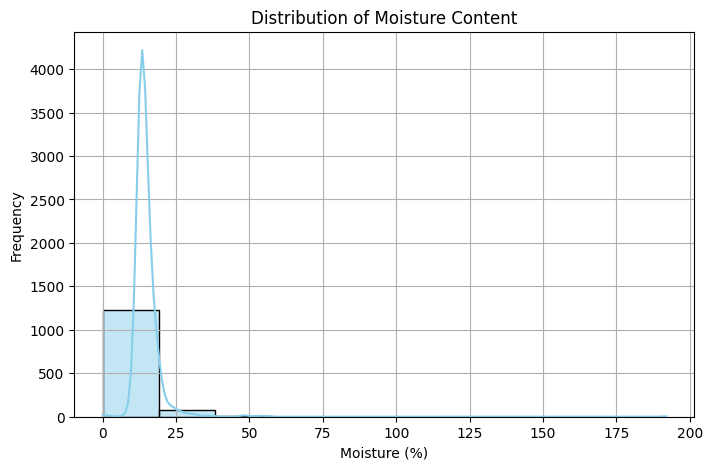

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.histplot(grain_data["moisture_maize_grain"], bins=10, kde=True, color="skyblue")
plt.title("Distribution of Moisture Content")
plt.xlabel("Moisture (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


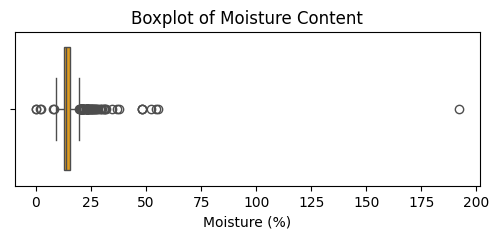

In [24]:
plt.figure(figsize=(6, 2))
sns.boxplot(x=grain_data["moisture_maize_grain"], color="orange")
plt.title("Boxplot of Moisture Content")
plt.xlabel("Moisture (%)")
plt.show()


### Check Unique Values and Spread

In [25]:
grain_data["moisture_maize_grain"].value_counts().sort_index()


moisture_maize_grain
0.0      2
2.0      1
2.1      1
7.7      1
8.0      1
        ..
48.3     2
52.3     1
54.3     1
55.6     1
192.0    1
Name: count, Length: 152, dtype: int64

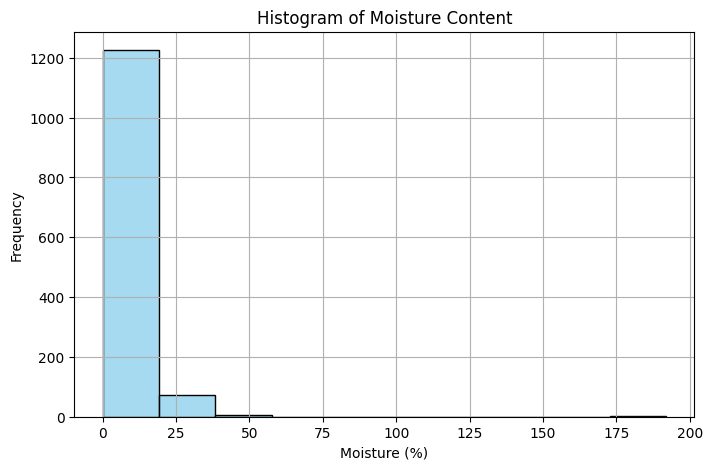

In [28]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(grain_data["moisture_maize_grain"], bins=10, kde=False, color="skyblue")
plt.title("Histogram of Moisture Content")
plt.xlabel("Moisture (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


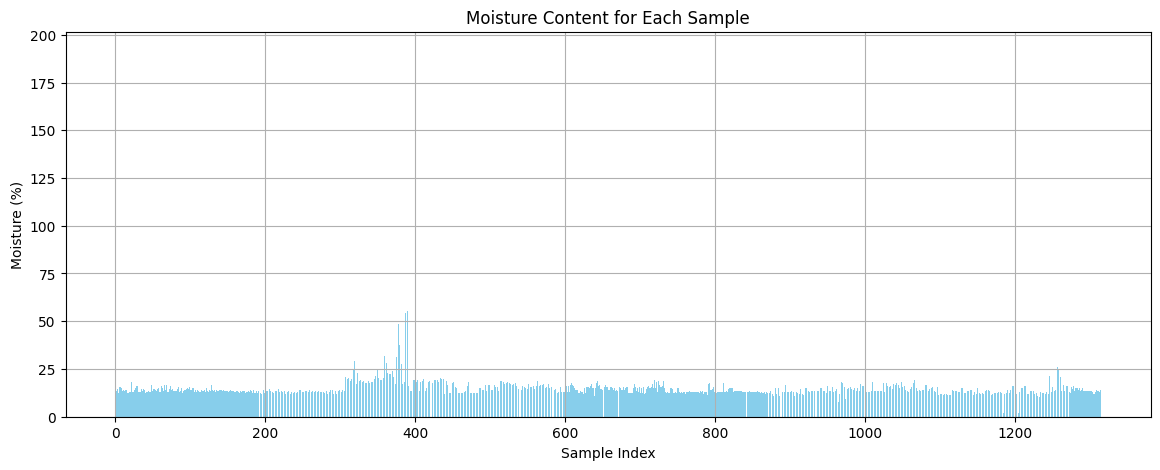

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.bar(x=range(len(grain_data["moisture_maize_grain"])), 
        height=grain_data["moisture_maize_grain"], 
        color='skyblue')

plt.title("Moisture Content for Each Sample")
plt.xlabel("Sample Index")
plt.ylabel("Moisture (%)")
plt.grid(True)
plt.show()


### Aflatoxin analysis

In [30]:
grain_data["total_aflatoxins_ug_kg_maize_grain"].describe()

count     1300.000000
mean        49.193615
std        582.545581
min          0.000000
25%          4.300000
50%          6.000000
75%         26.300000
max      20732.000000
Name: total_aflatoxins_ug_kg_maize_grain, dtype: float64